In [1]:
import sys
sys.path.append("..")

import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt
from jax import grad, jit, vmap
import numpyro
from numpyro import distributions as dist
from numpyro import infer

from numpyro_ext import distributions as distx
from numpyro_ext import info, optim

jax.config.update("jax_enable_x64", True)
numpyro.set_host_device_count(2)
jax.config.update('jax_disable_jit', True)

from jaxoplanet import light_curves, orbits
import arviz as az
import corner

from core.jax import oblate_lightcurve, compute_bounds

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Computing the Fisher information matrix of an oblate light curve model

In this notebook, I will show how to compute Fisher information of an oblate light curve model under the Laplace approximation (assuming the posterior on the oblateness parameters is a Gaussian distribution centered on the MAP (maximum a-posteriori) value.) Under this approximation, we can find the Cramér-Rao lower bound on the variance of the oblateness. 

Basically, this notebooks seeks to answer the question: Under the most optimistic of cases, what is it possible to know about the oblateness of a transiting exoplanet?

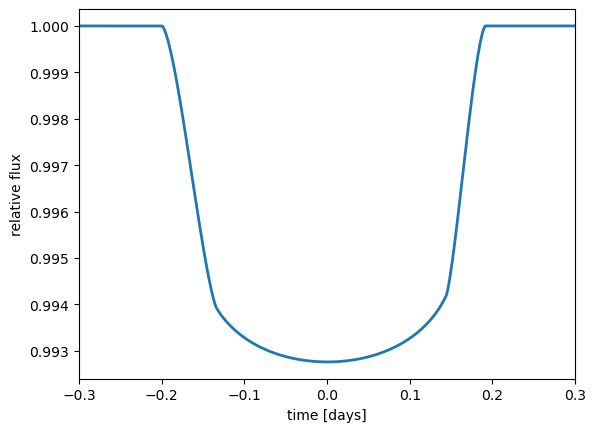

In [2]:
#Fiducial planet parameters:
params = {'period':300.456,
          'radius':0.1,
          'u':jnp.array([0.3,0.2]),
          'f':0.3,
          'bo':0.7,
          'theta':jnp.radians(35),
          'duration': 0.4
}
# The light curve calculation requires an orbit

# Compute a limb-darkened light curve using starry
t = jnp.linspace(-0.3, 0.3, 1000)
#oblate_lightcurve = jit(oblate_lightcurve)
lc = oblate_lightcurve(params,t)

plt.plot(t, lc, color="C0", lw=2)
plt.ylabel("relative flux")
plt.xlabel("time [days]")
_ = plt.xlim(t.min(), t.max())

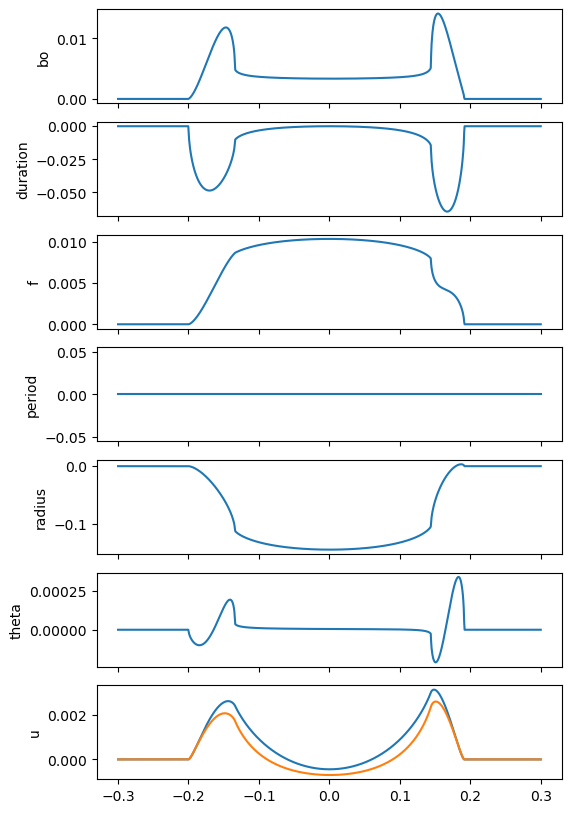

In [3]:
grad = jax.jacrev(oblate_lightcurve)
grads = grad(params, t)
_, axes = plt.subplots(len(grads.keys()), 1, figsize=(6, 10), sharex=True)
for n, key in enumerate(grads.keys()):
    axes[n].plot(t, grads[key])
    axes[n].set_ylabel(key)

In [4]:
import zodiax as zdx

class OblateTransitModel(zdx.Base):
    period: jnp.ndarray
    t0: jnp.ndarray
    radius: jnp.ndarray
    u: jnp.ndarray
    f: jnp.ndarray
    bo: jnp.ndarray
    theta: jnp.ndarray
    duration: jnp.ndarray
    t: jnp.ndarray
    
    def __init__(self, period, t0, radius, u, f, bo, theta, duration, t):
        self.period = period
        self.radius = radius
        self.t0 = t0
        self.u = u
        self.f = f
        self.bo = bo
        self.theta = theta
        self.duration = duration
        self.t = t
        
    def model(self):
      #Compute a limb-darkened light curve using starry
      params = {'period':self.period,
                't0':self.t0,
                'radius':self.radius,
                'u':self.u,
                'f':self.f,
                'bo':self.bo,
                'theta':self.theta,
                'duration': self.duration
        }
      lc = oblate_lightcurve(params,self.t)
      return lc

In [16]:
t = jnp.linspace(0.9,1.1,1000)

true_params = {'period':5.0,
               't0':1.0,
          'radius':0.1,
          'u':np.array([0.3,0.2]),
          'f':0.3,
          'bo':0.7,
          'theta':np.radians(35),
          'duration': 0.12
}
yerr = 50*1e-6

data = jnp.array(oblate_lightcurve(true_params, t-true_params['t0'])+yerr*np.random.normal(size=len(t)))

model = OblateTransitModel(jnp.array(5.0), jnp.array(1.0), jnp.array(0.1), jnp.array([0.3,0.2]), jnp.array(0.3), jnp.array(0.7), jnp.radians(35), jnp.array(0.12), t-true_params['t0'])

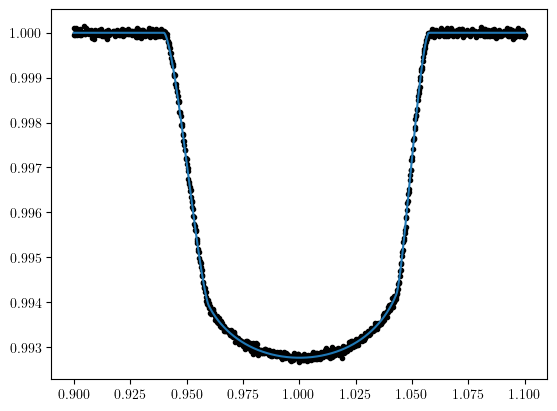

In [17]:
plt.plot(t, data, "k.", label="data")
plt.plot(t, model.model(), label="truth")

In [20]:
jax.config.update("jax_debug_nans", False)
opt_params = ['f', 'radius', 'theta', 'bo', 'u']
cov = zdx.covariance_matrix(model, opt_params, zdx.bayes.chi2_loglike, data)

In [21]:
yerr = 50*1e-8
data_lownoise = jnp.array(oblate_lightcurve(true_params, t-true_params['t0'])+yerr*np.random.normal(size=len(t)))
model_lownoise = OblateTransitModel(jnp.array(5.0), jnp.array(1.0), jnp.array(0.1), jnp.array([0.3,0.2]), jnp.array(0.3), jnp.array(0.7), jnp.radians(35), jnp.array(0.12), t-true_params['t0'])
cov_lownoise = zdx.covariance_matrix(model_lownoise, opt_params, zdx.bayes.chi2_loglike, data_lownoise)

/Users/uqsdhola/opt/anaconda3/lib/python3.9/site-packages/chainconsumer/chainconsumer.py:346: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  chain = np.random.multivariate_normal(mean, covariance, size=1000000)


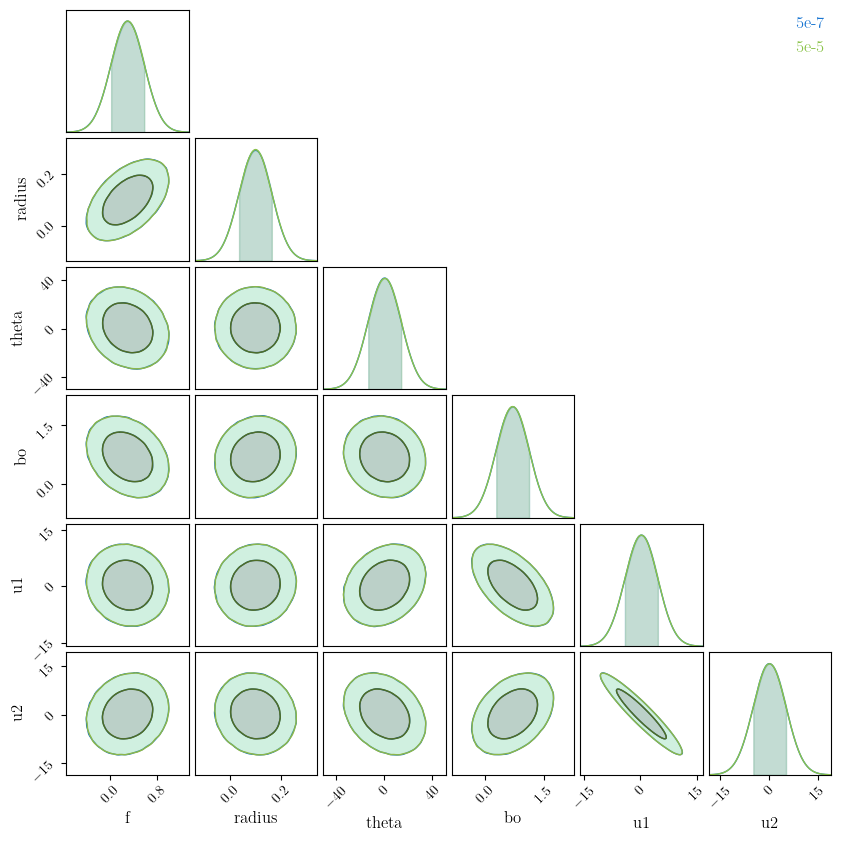

In [22]:
from chainconsumer import ChainConsumer
opt_params = ['f', 'radius', 'theta', 'bo', 'u1', 'u2']
X = np.array([model.f, model.radius, model.theta, model.bo, model.u[0], model.u[1]])
c = ChainConsumer()
c.add_covariance(X, cov_lownoise, parameters=opt_params, name='5e-7')
c.add_covariance(X, cov, parameters=opt_params, name='5e-5')
c.configure(serif=True, shade=True, bar_shade=True, shade_alpha=0.2, spacing=1., max_ticks=3)
fig = c.plotter.plot()

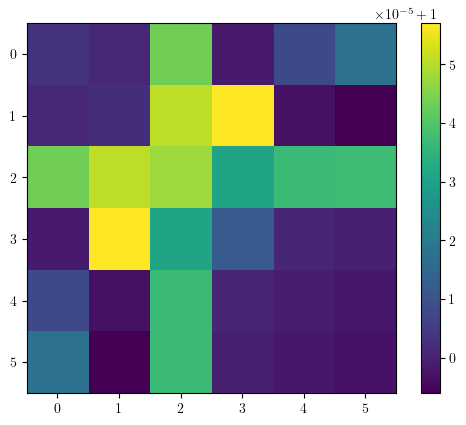

In [23]:
plt.imshow(cov/cov_lownoise)
plt.colorbar()

In [19]:
import zodiax as zdx
from jaxoplanet.light_curves import limb_dark_light_curve
from jaxoplanet.orbits import TransitOrbit



class TransitModel(zdx.Base):
    period: jnp.ndarray
    t0: jnp.ndarray
    radius: jnp.ndarray
    u: jnp.ndarray
    bo: jnp.ndarray
    duration: jnp.ndarray
    t: jnp.ndarray
    
    def __init__(self, period, t0, radius, u, bo, duration, t):
        self.period = period
        self.radius = radius
        self.t0 = t0
        self.u = u
        self.bo = bo
        self.duration = duration
        self.t = t
        
    def model(self):
      #Compute a limb-darkened light curve using starry
      
      orbit = TransitOrbit(period=self.period, duration=self.duration, time_transit=self.t0, impact_param=self.bo, radius=self.radius)
      lc = jax.vmap(limb_dark_light_curve(orbit, self.u))(t)
      return lc

In [36]:
t = jnp.linspace(0.9,1.1,1000)

true_params = {'period':5.0,
               't0':1.0,
          'radius':0.1,
          'u':np.array([0.3,0.2]),
          'bo':0.7,
          'duration': 0.12
}
yerr = 50*1e-6
orbit = TransitOrbit(period=true_params['period'], duration=true_params['duration'], time_transit=true_params['t0'], impact_param=true_params['bo'], radius=true_params['radius'])
data = jax.vmap(limb_dark_light_curve(orbit, true_params['u']))(t)+yerr*np.random.normal(size=len(t))

model = TransitModel(jnp.array(5.0), jnp.array(1.0), jnp.array(0.1), jnp.array([0.3,0.2]), jnp.array(0.7), jnp.array(0.12), t-true_params['t0'])

In [39]:
jax.config.update("jax_debug_nans", False)
opt_params = ['bo', 'radius']
fim = zdx.fisher_matrix(model, opt_params, zdx.bayes.chi2_loglike, data)

In [40]:
fim

Array([[0., 0.],
       [0., 0.]], dtype=float64)

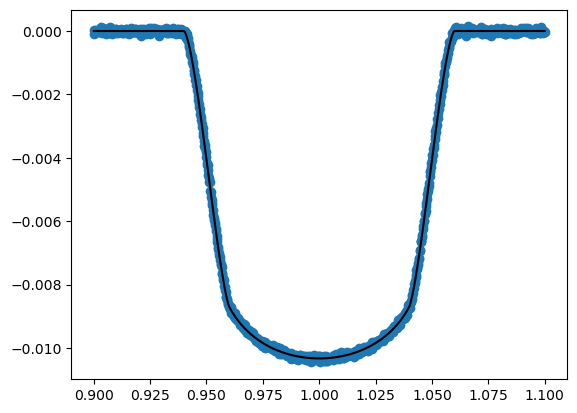

In [38]:
plt.scatter(t, data)
plt.plot(t, model.model(),c='k')